# Discovering the Star Trek Universe with spaCy ✨
#### An Introduction to modern Natural Language Processing

<br/>



# Christoph Schwienheer
#### @chs_sch

In [ ]:
# Christoph Schwienheer @chs_sch
# NOTE: Experimental setup, this code could be nicer 🖖
# Check imports for other requirements (default data science stack)
#
!pip install spacy==2.0.18


# Download large english spacy smodel
!spacy download en_core_web_lg

In [ ]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns

import spacy
import pandas as pd

from spacy import displacy
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import itertools

pylab.rcParams['figure.figsize'] = (30, 11)

sns.set()

# Plot a most_common counter result
def plot_counter(new_counter, title, xlabel, ylabel, ylim = None):

    labels, values = zip(*new_counter)
    indexes = np.arange(len(labels))
    width = 0.9
    plt.rcParams.update({'font.size': 102})
    plt.bar(indexes, values, width)
    plt.xticks(indexes, labels, fontsize=25, rotation=45)
    plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    if ylim:
        plt.ylim(ylim)
    
# Calculate realtive usage
def most_common_relative_usage(pos, person, all_counters, person_counters):
    ar = sorted([(round(d[1]/all_counters[pos][d[0]] if all_counters[pos][d[0]] else 1, 2), d[0]) for d in counters[person][pos].most_common(20)], reverse=True)
    return [(a[1], a[0]) for a in ar]


# Normalize warp
def normalize_warp(new_counter):
    for i, el in enumerate(["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen"]):
        for j, it in enumerate(new_counter):
            new_counter[j] = (it[0].replace(el, str(i)).replace("point", "."), it[1])

    for j, it in enumerate(new_counter):

        new_counter[j] = (float(it[0].replace(" ", "").replace("warp", "")), it[1])

    return new_counter

# Get data
def get_data():
    df = pd.read_csv("TNG.csv")
    # Only keep rows with a person as speaker
    df = df.dropna(subset=['who'])
    df = df.fillna("")
    # Normalize
    df.who = df.who.apply(lambda x: x.replace("V.O.", "").strip())
    df.text = df.text.apply(lambda x: x.strip())
    # Only keep main characters
    df = df.query('who == "PICARD" or who == "RIKER" or who == "WORF" or who == "DATA" or who == "BEVERLY" or who == "TROI"')
    df = df.reset_index()
    return df



def get_character_docs(df):
    docs = {}
    for character in df.who.unique():
        docs[character] = ""
        for e in df[df.who == character].text:
            # Create document with corpus
            doc = "".join([e.text_with_ws for e in nlp(e) if not e.is_stop and e.has_vector and not e.is_punct])
            docs[character] += doc + "\n"
        docs[character] = nlp(docs[character])

    return docs
    

# Props: https://towardsdatascience.com/reliving-avengers-infinity-war-with-spacy-and-natural-language-processing-2abcb48e4ba1    
def docs_similarities(subjects_docs):
    
    # Create a square ndarray of len(subjects_docs) filled with 1's
    similarities_matrix = np.full((len(subjects_docs), len(subjects_docs)), fill_value=1.0)

    for a, b in itertools.product(enumerate(subjects_docs), repeat=2):
        similarity_score = subjects_docs[a[1]].similarity(subjects_docs[b[1]])
        print("Similarity between {} and {} docs is {}".format(a[1], b[1], similarity_score))
        similarities_matrix[a[0], b[0]] = similarity_score

    plt.matshow(similarities_matrix, interpolation='nearest', cmap=cm.get_cmap('YlGnBu'))
    plt.yticks(range(len(subjects_docs)), subjects_docs.keys())
    plt.xticks(range(len(subjects_docs)), subjects_docs.keys(), rotation='vertical')
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.colorbar()
    plt.title("Character's Corpus Similarity Matrix")

    plt.savefig("similarity_matrix.png", bbox_inches='tight')
    plt.close()
    return plt

        

In [ ]:
!wget https://github.com/RTrek/startrekTNGdataset/raw/master/data2/TNG.csv

In [ ]:
df = get_data()

# Natural Language Processing

Natural language processing (NLP) is a subfield of computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

https://en.wikipedia.org/wiki/Natural_language_processing


# spaCy

- Python API
- Very fast (using Cython under the hood)
- Support for 49+ languages
- Widely used in industry
- Widely used in research for preprocessing
- Based on modern neural network architectures
- Is developing towards a NLP ecosystem


# NLP Tasks

- **Tokenization**: Splitting up words and sentences
- **Part of Speech Tagging (POS):** Which word is a noun, verb... ?
- **Dependency Parsing (DEP)** Which word is the object, subject ... ?
- **Named Entity Regocnition (NER)** What is an organization, person ... ?
- **Text Classification** To which category belongs a sentece or document ?
---
- **Machine Translation**
- **Question Answering**
- **Coreference Resolution**

(https://nlpprogress.com/)


# Agenda

- We'll experiment with the spaCy API on small examples
- I'll show additional text analyses on a larger dataset

---

- Named entitiy recognition
- Part-of-speech tagging
- Word representation and  similarities
- Custom models for specific problems




# spaCy NLP Pipeline

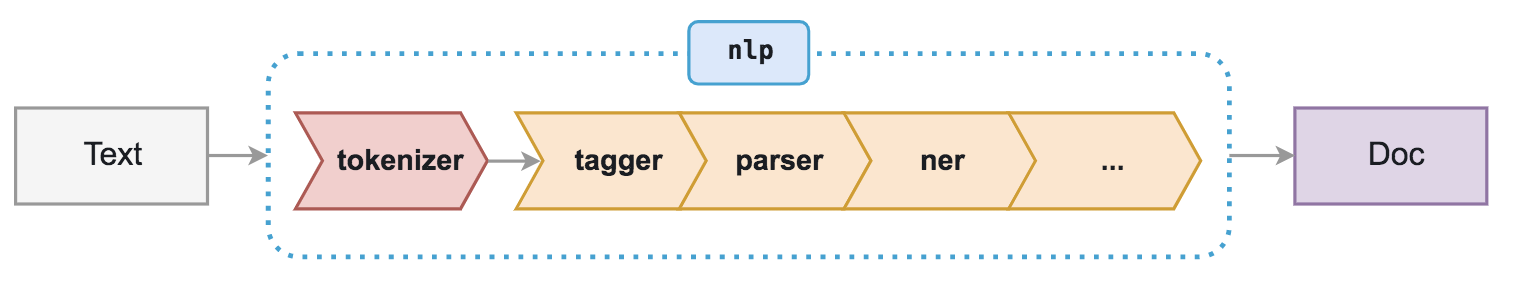
https://spacy.io
### Workshop Notebook 
- 1. Tokenizer
- 2. Named Entity Recognition
- 3. Part of Speech Tagging

# Analyzing TNG scripts

In [89]:
df = get_data()
df[['episode', 'who','text', 'imdbRating']].head()

,episode,who,text,imdbRating
0,encounter at farpoint,PICARD,"Captain's log, stardate 42353.7. Our destinati...",6.9
1,encounter at farpoint,PICARD,"My orders are to examine Farpoint, a starbase ...",6.9
2,encounter at farpoint,PICARD,"acquainted with my new command, this Galaxy Cl...",6.9
3,encounter at farpoint,PICARD,I am still somewhat in awe of its size and com...,6.9
4,encounter at farpoint,PICARD,"several key positions, most notably ...",6.9


### We use Python's collections.Counter to count occurences of POS, NER and other matches in the text

In [90]:
from collections import Counter
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_lg")
df = get_data()

matcher = Matcher(nlp.vocab)
pattern = [{"LOWER": "warp"}, {"LIKE_NUM": True, "OP": "+"}, {"LOWER": "point", "OP": "?"}, {"LIKE_NUM": True, "OP": "?"}]
matcher.add("WARP", None, pattern)

crew = get_data().who.unique()
pos_types = ["VERB", "NOUN"]

warp_counter = Counter()

counters = {}
all_counters = {}

for pos_type in pos_types:
    all_counters[pos_type] = Counter()

for person in crew:
    if not person in counters:
        counters[person] = {}
    
    for pos_type in pos_types:
        counters[person][pos_type] = Counter()
    
def get_tuple():
    for idx, row in df.iterrows():
        yield (row.text, (idx, row))


In [91]:
%%time
for (doc, (idx, row)) in nlp.pipe(get_tuple(), as_tuples=True):
    
    if idx % 1000 == 0:
        print(idx)
        
    if row.who in crew:

        # Count ents
        for word in doc:
         
            if word.pos_ in pos_types and word.lemma_ not in spacy.lang.en.stop_words.STOP_WORDS:
                counters[row.who][word.pos_][word.lemma_] += 1
                all_counters[word.pos_][word.lemma_] += 1
                
        for word in doc.ents:
            if word.label_ in pos_types:
                counters[row.who][word.label_][word.lemma_] += 1
                
        # Count Ents
        for word in doc.ents:
            if word.label_ in pos_types:
                #print("imdb", row.imdbRating)
                if row.imdbRating and type(row.imdbRating) == float:
                    all_counters[word.label_ + '_imdb'][word.lemma_] += row.imdbRating
                    all_counters[word.label_][word.lemma_] += 1
                
        
        matches = matcher(doc)
        texts = []
        
        for match_id, start, end in matches:
            string_id = nlp.vocab.strings[match_id] # Get string representation
            span = doc[start:end]  # The matched span
            texts.append(span.text)
        
        if texts:
            warp_counter[texts[-1].lower()] += 1
          

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
CPU times: user 4min 45s, sys: 6min 25s, total: 11min 11s
Wall time: 1min 30s


# Which verbs are used by the crew?

- Calculate relative usage of 30 most common verbs per crew member

In [92]:
usage_picard = most_common_relative_usage("VERB", "PICARD", all_counters, counters)
usage_troi = most_common_relative_usage("VERB", "TROI", all_counters, counters)
usage_worf = most_common_relative_usage("VERB", "WORF", all_counters, counters)

# Stereotype 1: Picard speaks diplomatic

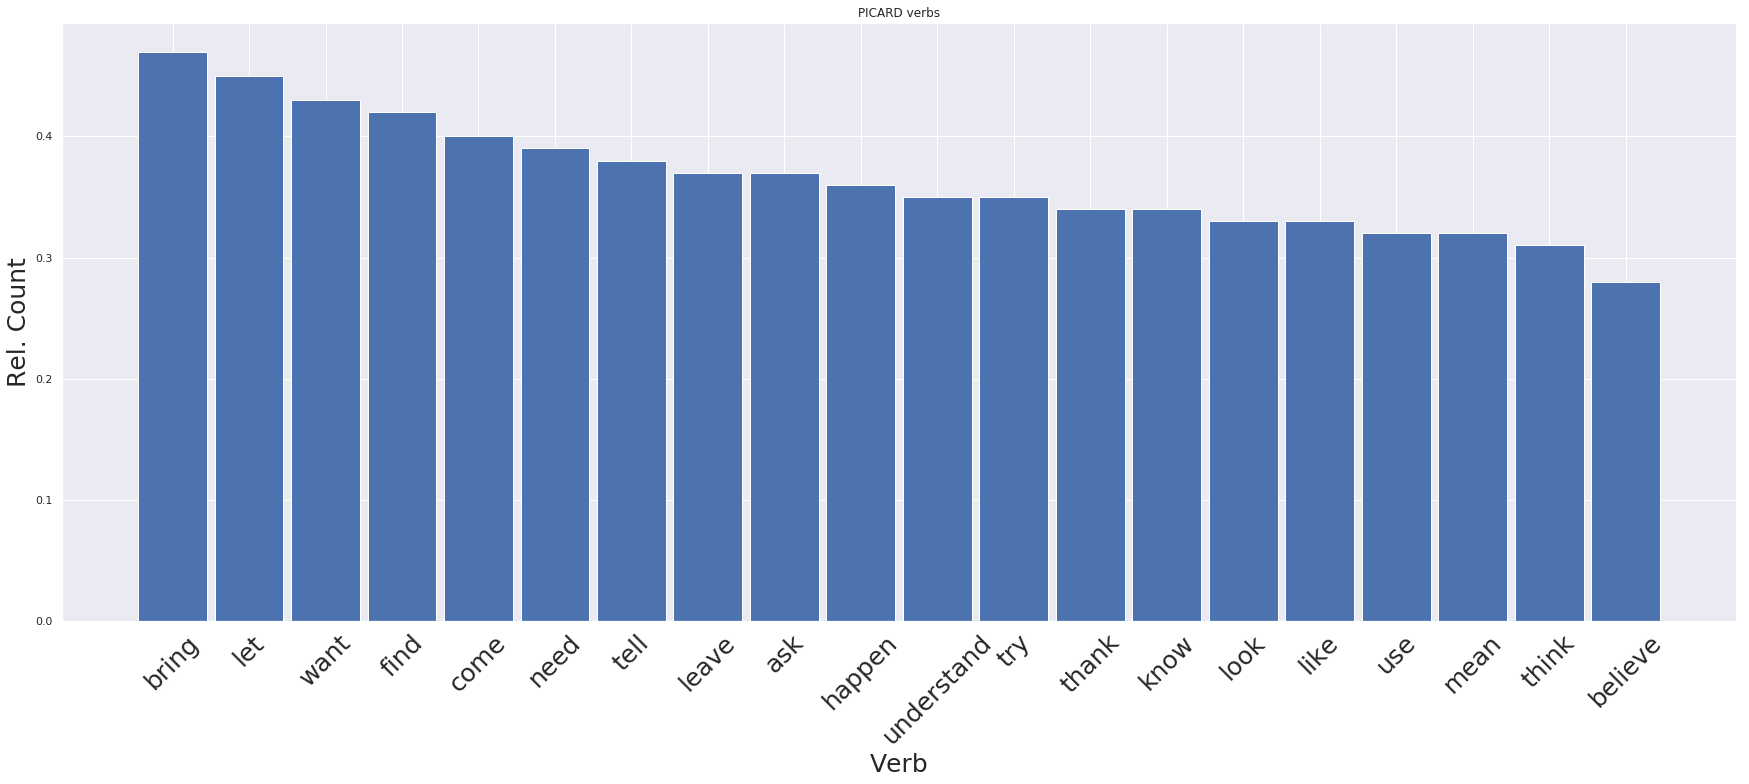

In [93]:
plot_counter(usage_picard, "PICARD verbs", "Verb", "Rel. Count")

#  Stereotype 2: Troi speaks emotional

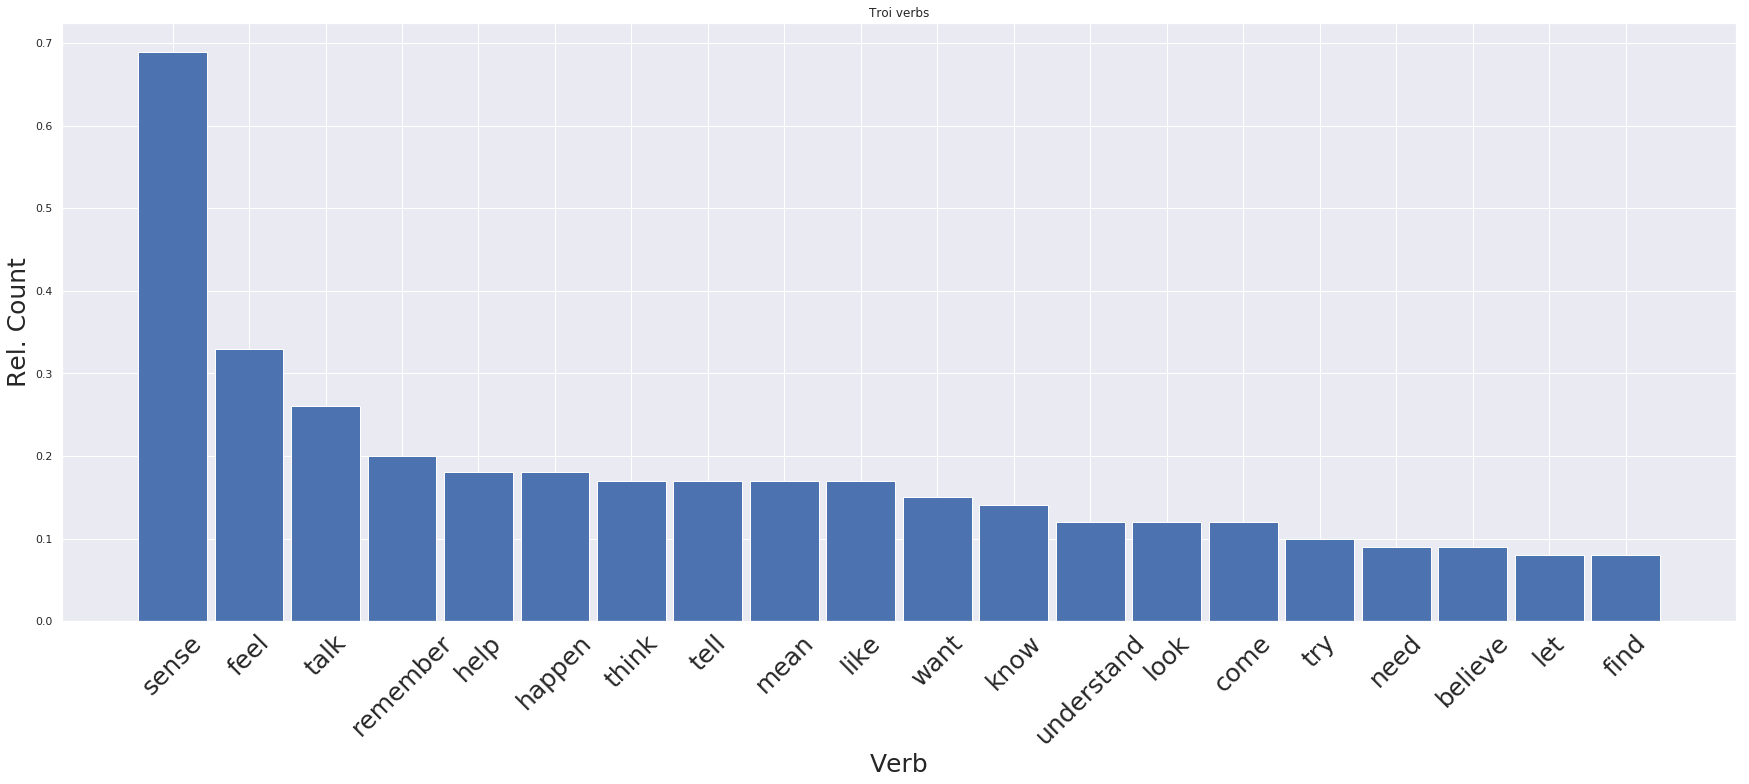

In [94]:
plot_counter(usage_troi, "Troi verbs", "Verb", "Rel. Count")

#  Stereotype 3: Worf is sometimes aggressive

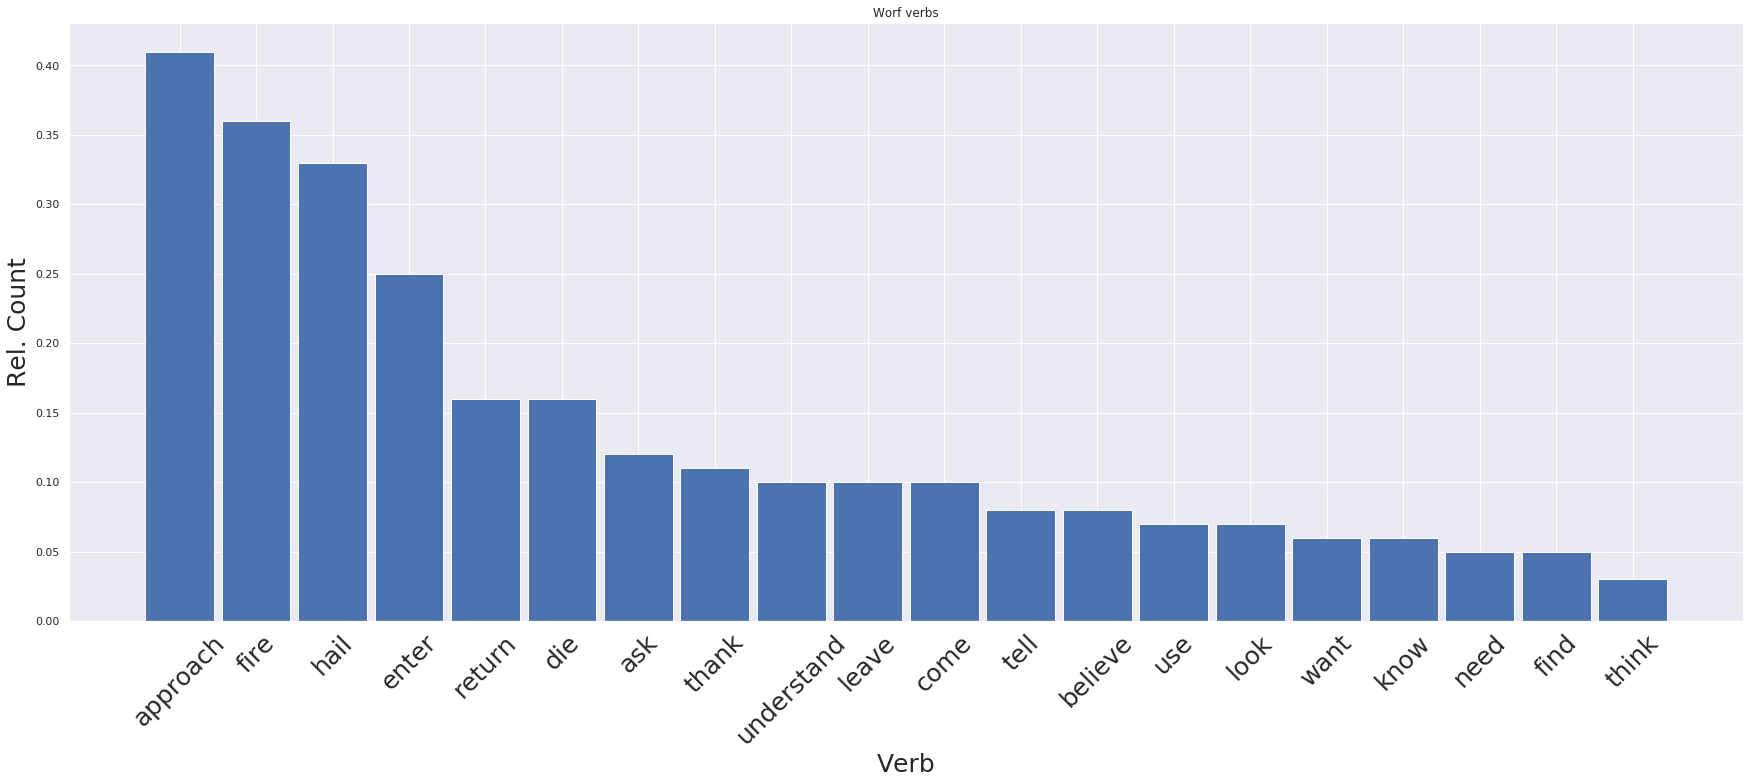

In [95]:
plot_counter(usage_worf, "Worf verbs", "Verb", "Rel. Count")

#  Matcher - How fast do we travel in space?
#### Workshop Notenbook 5: Matcher

In [96]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern = [{"LOWER": "warp"}, {"LIKE_NUM": True, "OP": "+"}, {"LOWER": "point", "OP": "?"}, {"LIKE_NUM": True, "OP": "?"}]
matcher.add("WARP", None, pattern)

doc = nlp(u"We're now at warp nine point three.")

matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]  # The matched span
    print(span)

warp nine point three


#  Matcher - How fast do we travel in space?

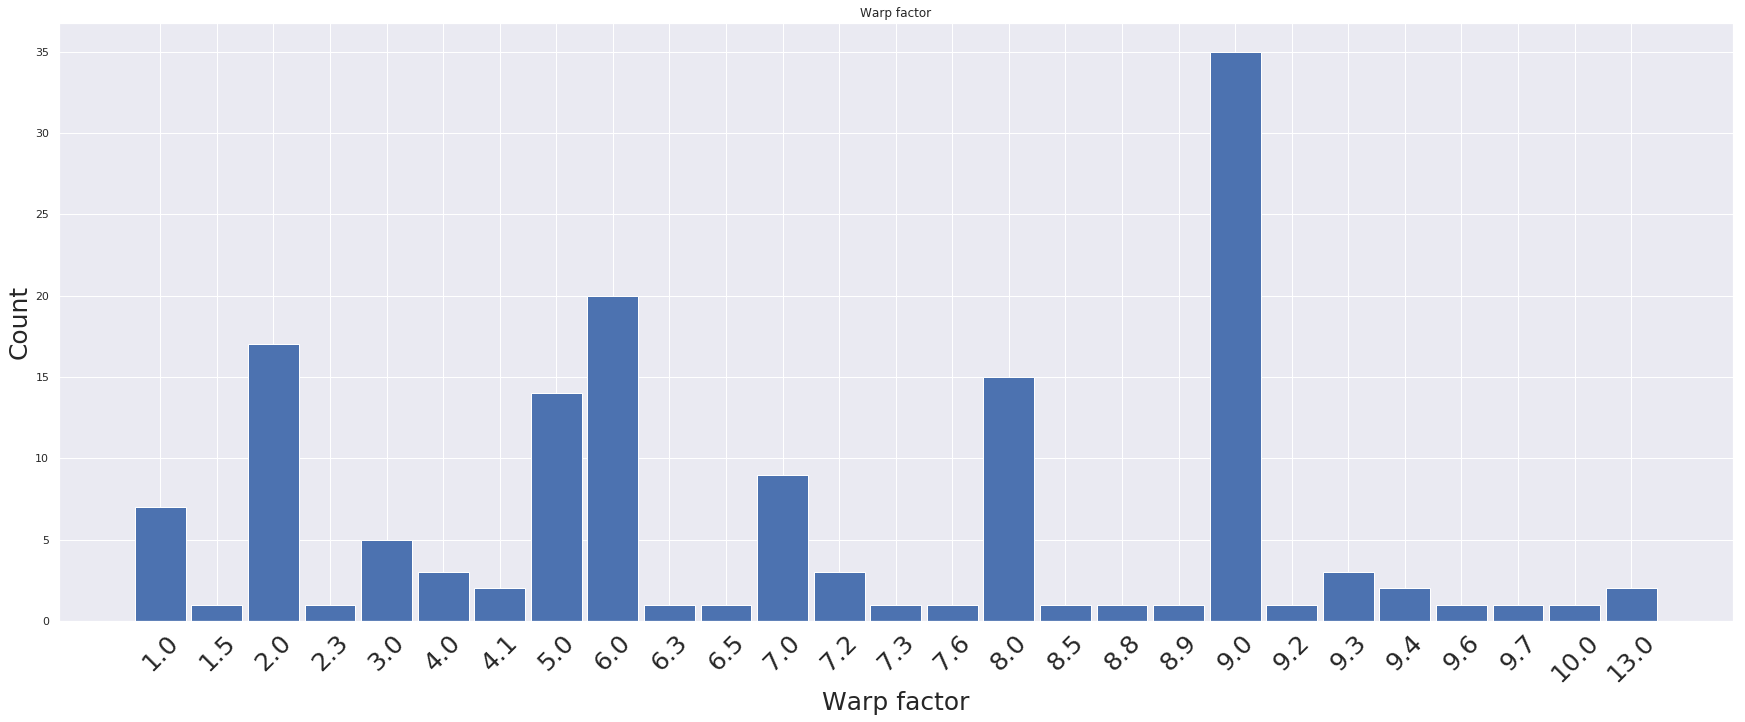

In [97]:
warps = sorted(normalize_warp(warp_counter.most_common()))
plot_counter(warps, "Warp factor", "Warp factor", "Count")

#  Matcher - Warp 13?

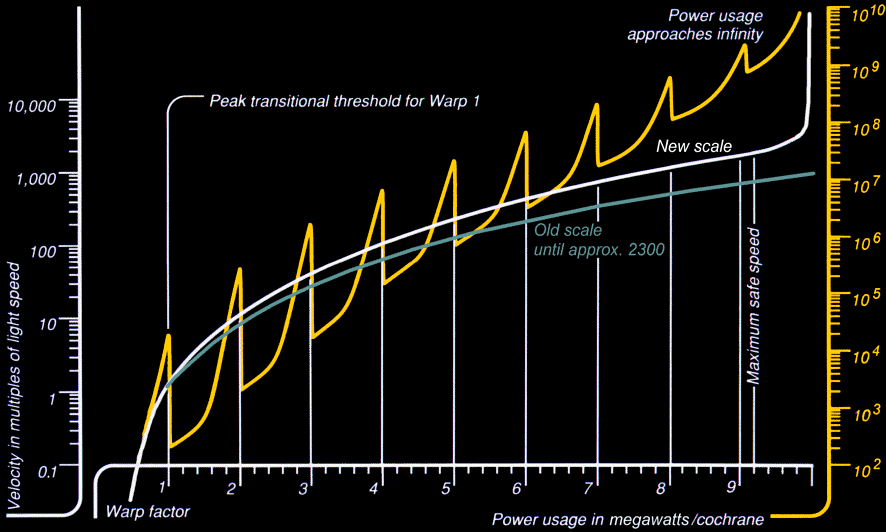
https://scifi.stackexchange.com/questions/35539/warp-13-was-this-overlooked

#  Matcher - How fast do we travel in space?

In [98]:
# Task: This can be a one liner :)
total = 0 
counts = 0
for (factor, count) in warps:
    total += factor * count
    counts += count
print("Average travel speed", total / counts)

Average travel speed 6.364666666666667


#  Word and document similarities

- Every word is represented by a vector (word embeddings)
- A sentence or document can be represented by a vector (e.g. taking the avarage of all word vectors) 
- Similarity measures can be applied on vectors (e.g. cosine similarity)

---

### Workshop Notebook: 5.  Representations and Similarities


#  Similarity Matrix - Compare corpus of crew members


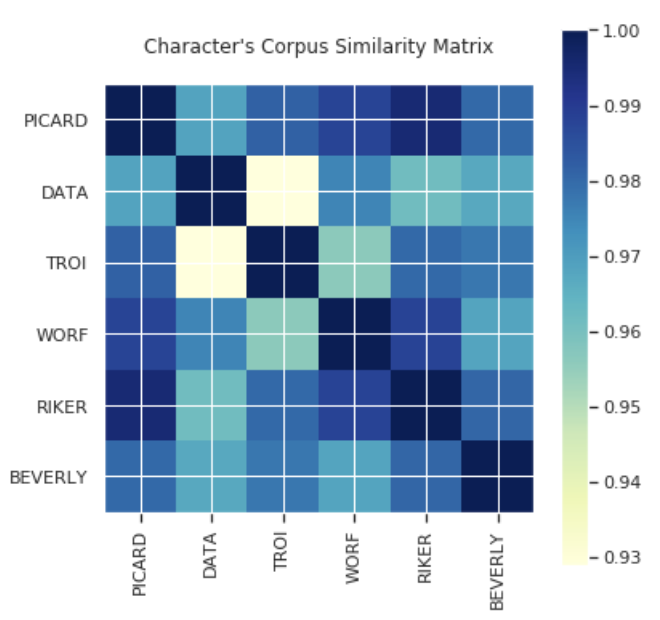

# Train own statistical models
- spaCy has it's own ML/Neural Network library (thinc)
- Using mostly Convolutional Neural Networks
- Supports transfer learning
- Version 2.1 pretrained models

# Train own models -  Named Entity Recognition

In [100]:
# Just toy example run code in the next cells
 
TRAIN_DATA = [
    ("I've got a problem down here on Risa!", {'entities': [(32, 36, 'SPACE_DESTINATION')]}),
    ("Captain, the Borg are using their combined power to repair the ship.",{"entities":[(13,17,"ALIEN_SPECIES")]})
]

nlp = spacy.blank('en')  # create blank model

ner = nlp.create_pipe('ner')
nlp.add_pipe(ner, last=True)
       
# add labels
ner.add_label("SPACE_DESTINATION")
ner.add_label("ALIEN_SPECIES")
    
optimizer = nlp.begin_training()

# Simplified, we also use minibatching and dropout
for i in range(20):
    random.shuffle(TRAIN_DATA)
    for text, annotations in TRAIN_DATA:
        nlp.update([text], [annotations], sgd=optimizer)
        

In [82]:
!wget https://github.com/chssch/spacy-models/raw/master/train.json

--2019-05-11 09:22:56--  https://github.com/chssch/spacy-models/raw/master/train.json
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chssch/spacy-models/master/train.json [following]
--2019-05-11 09:22:56--  https://raw.githubusercontent.com/chssch/spacy-models/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222133 (217K) [text/plain]
Saving to: ‘train.json’

train.json          100%[===================>] 216.93K  --.-KB/s    in 0.02s   

2019-05-11 09:22:57 (10.4 MB/s) - ‘train.json’ saved [222133/222133]



In [102]:
import json

with open('train.json', 'r') as f:
    TRAIN_DATA = json.load(f)
    

In [ ]:
# Not optimized
# No validation

import spacy
import random
from spacy.util import minibatch, compounding

def train_spacy(data, iterations):

    TRAIN_DATA = data
    nlp = spacy.blank('en')  # create blank model
     
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)
       
    # add labels
    ner.add_label("SPACE_DESTINATION")
    ner.add_label("ALIEN_SPECIES")

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print("Statring iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts, 
                    annotations,
                    drop=0.4,  
                    sgd=optimizer, 
                    losses=losses)
            print(losses)
            
    return nlp

nlp = train_spacy(TRAIN_DATA, 20)

nlp.to_disk("tng_ner_model")


# Custom NER for "Alien Species" and "Space Destinations"

### Workshop Notebook: 6. Using custom models

In [ ]:
!pip install https://github.com/chssch/spacy-models/raw/master/en_tng_ner-0.0.1.tar.gz
!spacy link en_tng_ner en_tng_ner

In [110]:
nlp_tng = spacy.load("en_tng_ner")
df_subset = df.sample(frac=0.05)

In [111]:
# Batch processing
for doc in nlp_tng.pipe((it.text for _, it in df_subset.iterrows())):
    if doc.ents:
        displacy.render(doc, style='ent', jupyter=True, options={"ents": ["ALIEN_SPECIES", "SPACE_DESTINATION"], "colors": {"ALIEN_SPECIES": "#AA3939",  "SPACE_DESTINATION": "#2D882D"}})

In [112]:
%%time

df = get_data()

crew = get_data().who.unique()
pos_types = ["ALIEN_SPECIES", "ALIEN_SPECIES_imdb", "SPACE_DESTINATION", "SPACE_DESTINATION_imdb"]

tng_counters = {}

for pos_type in pos_types:
    tng_counters[pos_type] = Counter()

def get_tuple():
    for idx, row in df.iterrows():
        yield (row.text, (idx, row))

# Batch processing        
for (doc, (idx, row)) in nlp_tng.pipe(get_tuple(), as_tuples=True):
    
    if idx % 1000 == 0:
        print(idx)
        
    if row.who in crew:
        
        # Count Ents
        for word in doc.ents:
            if word.label_ in pos_types:
               
                if row.imdbRating and type(row.imdbRating) == float:
                    tng_counters[word.label_ + '_imdb'][word.lemma_] += row.imdbRating
                    tng_counters[word.label_][word.lemma_] += 1
                    
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
CPU times: user 1min 48s, sys: 2min 30s, total: 4min 18s
Wall time: 38.9 s


# Which aliens are most popular?

In [113]:
avg_imdb_per_species_occurance = {}
for species, count in tng_counters['ALIEN_SPECIES'].items():
    if count > 10:
        avg_imdb_per_species_occurance[species] = round(tng_counters['ALIEN_SPECIES_imdb'][species] / count, 2)
counter = Counter(avg_imdb_per_species_occurance)

In [114]:
counter.most_common()

[('Borg', 8.67),
 ('Tamarian', 8.6),
 ('Vulcan', 8.05),
 ('Cardassians', 8.04),
 ('Cardassian', 8.02),
 ('Bajoran', 7.97),
 ('Romulan', 7.91),
 ('Romulans', 7.88),
 ('Q', 7.66),
 ('Begin', 7.66),
 ('Belay', 7.66),
 ('Klingon', 7.53),
 ('Kes', 7.4),
 ('Klingons', 7.39),
 ('Ferengi', 6.81),
 ('Betazoid', 6.76),
 ('Ullians', 6.3)]

# Which aliens are most popular?

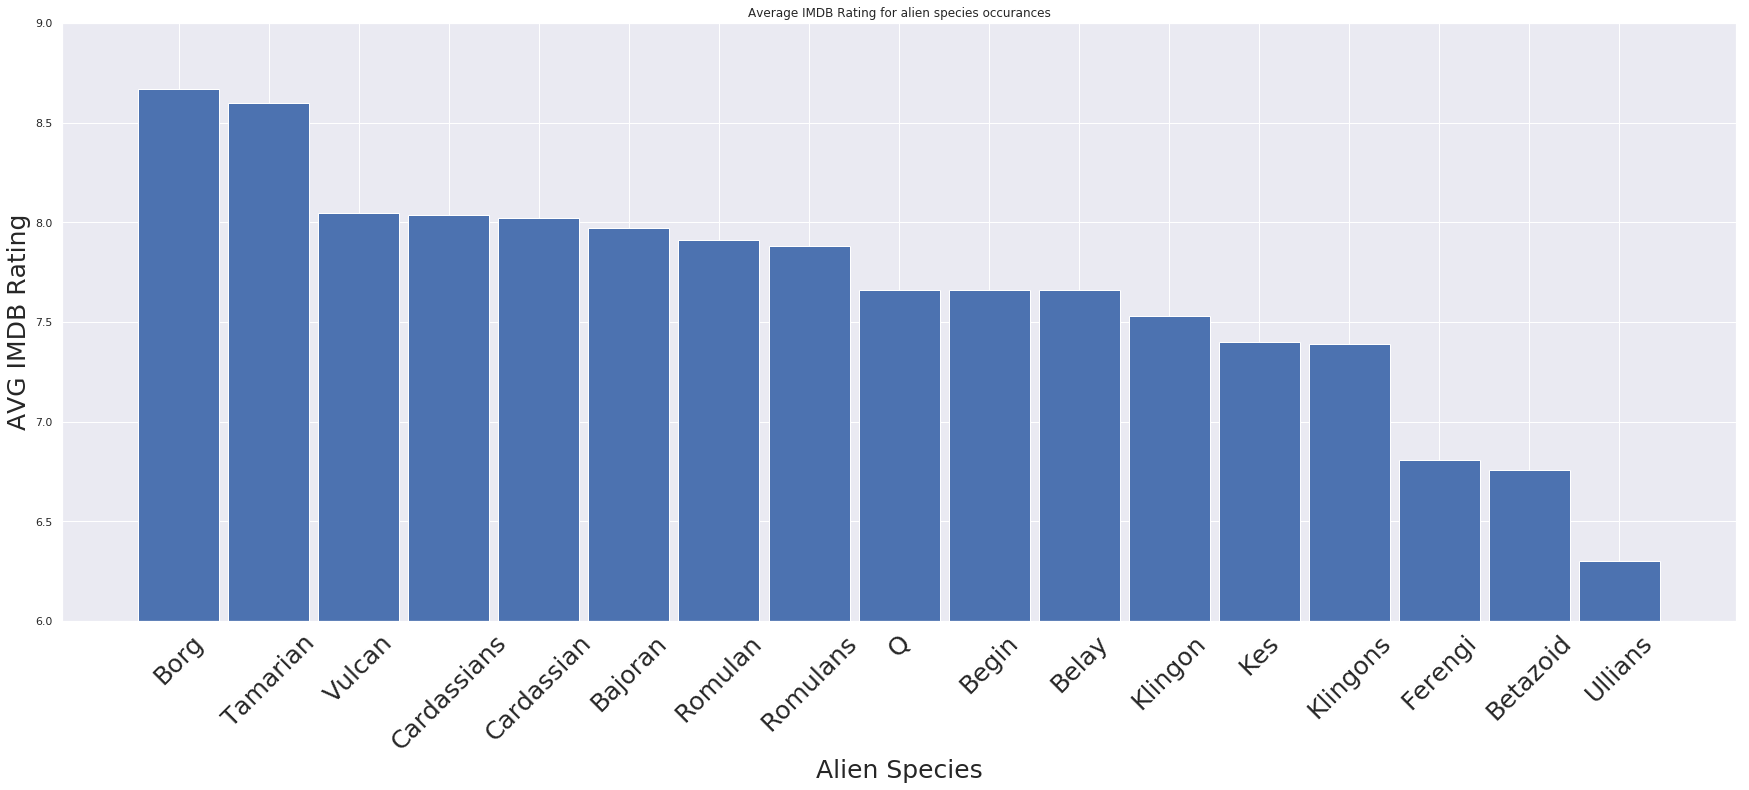

In [115]:
plot_counter(counter.most_common(), "Average IMDB Rating for alien species occurances", "Alien Species", "AVG IMDB Rating", ylim=(6, 9))

# Which aliens are most popular? Tamarian?

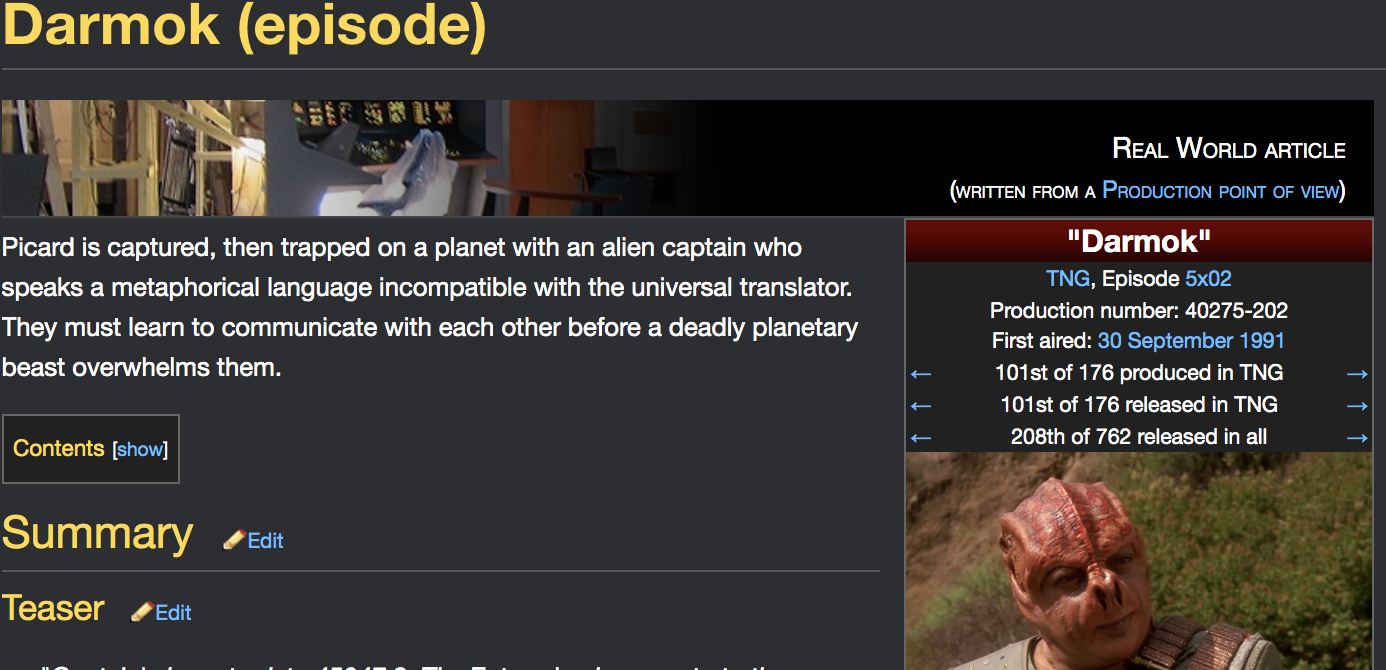

Machine Translation failing in the 24th century: https://memory-alpha.fandom.com/wiki/Darmok_(episode)


# Thanks🖖
### Discussion, Questions?